# Ames housing

In [7]:
# PEP-8: group imports from standard library first, alphabetical order
from pathlib import Path # use pathlib for working with paths
import sys
import tarfile
import warnings

# imports from third-party modules
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import requests
from requests.compat import urljoin
import sklearn
import seaborn as sns


**Import data**

There are three versions of the data: the entire data set and the train en test sets of the original data. Import the three versions.

In [11]:
ames = pd.read_csv("https://github.com/jads-nl/discover-projects/blob/main/ames-housing/AmesHousing.csv?raw=true")
ames.shape

(2930, 82)

In [15]:
traindata = pd.read_csv("https://raw.githubusercontent.com/jads-nl/discover-projects/e0426e645376da2af98b557c595dadcd0d57d8b1/ames-housing/test.csv")

In [16]:
traindata.shape

(1459, 80)

In [19]:
testdata = pd.read_csv("https://raw.githubusercontent.com/jads-nl/discover-projects/e0426e645376da2af98b557c595dadcd0d57d8b1/ames-housing/test.csv")

In [20]:
testdata.shape

(1459, 80)

In [3]:
ames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
Order              2930 non-null int64
PID                2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2440 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Alley              198 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         29

## Checking the missing values

Visualize missing values of a `pandas` data frame: https://dev.to/tomoyukiaota/visualizing-the-patterns-of-missing-value-occurrence-with-python-46dj

Another package to explore missing value patterns: missingno

see: https://github.com/ResidentMario/missingno

https://www.kaggle.com/jpmiller/patterns-of-missing-data




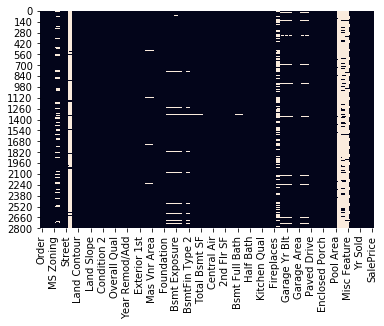

In [9]:
sns.heatmap(ames.isnull(), cbar=False)

In [10]:
ames.describe()

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2930.00000,2.930000e+03,2930.000000,2440.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2907.000000,...,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000
mean,1465.50000,7.144645e+08,57.387372,69.224590,10147.921843,6.094881,5.563140,1971.356314,1984.266553,101.896801,...,93.751877,47.533447,23.011604,2.592491,16.002048,2.243345,50.635154,6.216041,2007.790444,180796.060068
std,845.96247,1.887308e+08,42.638025,23.365335,7880.017759,1.411026,1.111537,30.245361,20.860286,179.112611,...,126.361562,67.483400,64.139059,25.141331,56.087370,35.597181,566.344288,2.714492,1.316613,79886.692357
min,1.00000,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,733.25000,5.284770e+08,20.000000,58.000000,7440.250000,5.000000,5.000000,1954.000000,1965.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129500.000000
50%,1465.50000,5.354536e+08,50.000000,68.000000,9436.500000,6.000000,5.000000,1973.000000,1993.000000,0.000000,...,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,160000.000000
75%,2197.75000,9.071811e+08,70.000000,80.000000,11555.250000,7.000000,6.000000,2001.000000,2004.000000,164.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213500.000000
max,2930.00000,1.007100e+09,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,...,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


In [12]:
ames.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


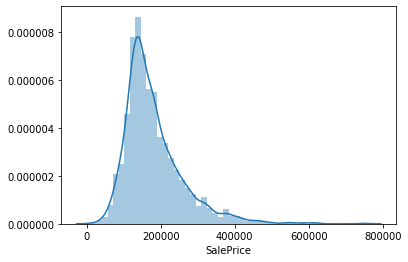

In [17]:
sns.distplot(ames['SalePrice'])

In [21]:
ames['SalePrice'].skew()

1.7435000757376466

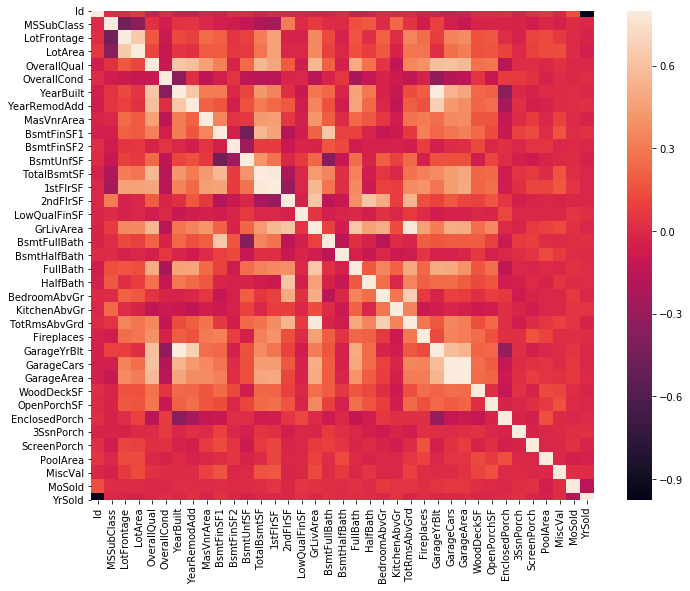

In [22]:
corrmat = traindata.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [25]:
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(traindata[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

KeyError: 'SalePrice'